In [6]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import load_mpl_presets, mpl_loc, fancy_legend, named_colors
import numpy as np
import vice
import sys
import os
print(sys.version_info)
load_mpl_presets()

sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [7]:
vice.yields.ccsne.settings['o'] = 0.015
vice.yields.sneia.settings['o'] = 0
vice.yields.ccsne.settings['fe'] = 0.0012
vice.yields.sneia.settings['fe'] = 0.00214

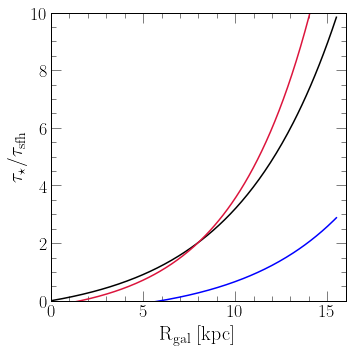

In [8]:
fig = plt.figure(figsize = (5, 5), facecolor = "white")
ax = fig.add_subplot(111)
ax.set_xlabel(r"R$_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_\star / \tau_\text{sfh}$")
ax.set_xlim([0, 16])
ax.set_ylim([0, 10])

def taustar_on_tausfh(rgal, slope = -0.08, yocc = 0.015):
    Z_oxygen = 10**(slope * (rgal - 8)) * vice.solar_z['o']
    return yocc / Z_oxygen - 1 + 0.4

xvals = np.linspace(0, 15.5, 200)
yvals = [taustar_on_tausfh(_) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["black"])

yvals = [taustar_on_tausfh(_, slope = -0.1) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

yvals = [taustar_on_tausfh(_, yocc = 0.005) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["blue"])

plt.tight_layout()
plt.show()

In [9]:
class exponential:
    
    def __init__(self, norm = 10, timescale = 1):
        self.norm = norm
        self.timescale = timescale
        
    def __call__(self, x):
        return self.norm * np.exp(-x / self.timescale)
    
class linear_exponential(exponential):
    
    def __call__(self, x):
        return x * super().__call__(x)

7.25


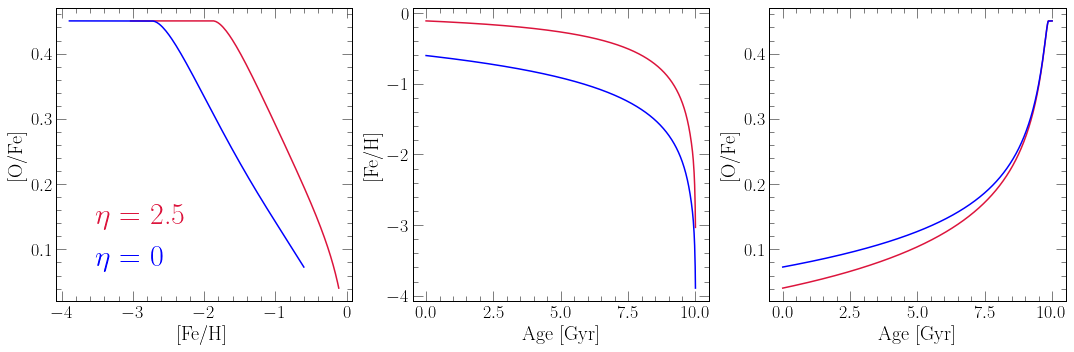

In [24]:
fig = plt.figure(figsize = (15, 5), facecolor = "white")
axes = []
xlabels = ["[Fe/H]", "Age [Gyr]", "Age [Gyr]"]
ylabels = ["[O/Fe]", "[Fe/H]", "[O/Fe]"]
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel(ylabels[i])

with vice.singlezone(name = "tmp") as sz:
    sz.func = exponential(timescale = 50)
    sz.mode = "sfr"
    sz.tau_star = 10
    out = sz.run(np.linspace(0, 10, 1001), capture = True, overwrite = True)
    kwargs = {
        "c": named_colors()["crimson"],
        "label": r"$\eta$ = %g" % (sz.eta)
    }
    axes[0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)
    axes[1].plot(out.history["lookback"], out.history["[fe/h]"], **kwargs)
    axes[2].plot(out.history["lookback"], out.history["[o/fe]"], **kwargs)
    factor = (1 + sz.eta - 0.4 - sz.tau_star / sz.func.timescale) / (1 - 0.4 - sz.tau_star / sz.func.timescale)
    factor = abs(factor)
    print(factor)

with vice.singlezone(name = "tmp") as sz:
    vice.yields.ccsne.settings['o'] /= factor
    vice.yields.ccsne.settings['fe'] /= factor
    vice.yields.sneia.settings['fe'] /= factor
    sz.func = exponential(timescale = 50)
    sz.mode = "sfr"
    sz.eta = 0
    sz.tau_star = 10
    out = sz.run(np.linspace(0, 10, 1001), capture = True, overwrite = True)
    kwargs = {
        "c": named_colors()["blue"],
        "label": r"$\eta$ = %g" % (sz.eta)
    }
    axes[0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)
    axes[1].plot(out.history["lookback"], out.history["[fe/h]"], **kwargs)
    axes[2].plot(out.history["lookback"], out.history["[o/fe]"], **kwargs)
    vice.yields.ccsne.settings['o'] *= factor
    vice.yields.ccsne.settings['fe'] *= factor
    vice.yields.sneia.settings['fe'] *= factor
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "bbox_to_anchor": (0.01, 0.01),
    "fontsize": 30
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

plt.tight_layout()
plt.show()